# Определение соответствия описания фото


Описание данных:
- **train_dataset.csv** -  информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний.
- **train_images** - изображения для тренировки модели
- **CrowdAnnotations.tsv** -  данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных (имя файла изображения; идентификатор описания; доля людей, подтвердивших, что описание соответствует изображению; количество человек, подтвердивших, что описание соответствует изображению; количество человек, подтвердивших, что описание не соответствует изображению).
- **ExpertAnnotations.tsv** - данные по соответствию изображения и описания, полученные в результате опроса экспертов (имя файла изображения; идентификатор описания).
- **test_queries.csv** - находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний.
- **test_images** - содержатся изображения для тестирования модели.


## Импорт библиотек и загрузка данных

In [1]:
!pip install deepface -q

In [2]:
import random
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, zipfile, io, requests
from PIL import Image
# from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from deepface import DeepFace
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
random.seed(42)

In [4]:
# Папка для данных
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

url = "https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip"

def download_and_extract(url, target_dir):
    """Скачать и распаковать архив по ссылке"""
    r = requests.get(url, stream=True)
    r.raise_for_status()
    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        z.extractall(target_dir)
        print("✅ Датасет скачан и распакован")
        return z.namelist()


files = download_and_extract(url, data_dir)
print("Файлы в архиве:", files[:20])  # посмотрим первые 20


✅ Датасет скачан и распакован
Файлы в архиве: ['to_upload/', 'to_upload/test_images/', 'to_upload/test_images.csv', '__MACOSX/to_upload/._test_images.csv', 'to_upload/.DS_Store', '__MACOSX/to_upload/._.DS_Store', 'to_upload/train_dataset.csv', '__MACOSX/to_upload/._train_dataset.csv', 'to_upload/ExpertAnnotations.tsv', '__MACOSX/to_upload/._ExpertAnnotations.tsv', 'to_upload/CrowdAnnotations.tsv', '__MACOSX/to_upload/._CrowdAnnotations.tsv', 'to_upload/train_images/', 'to_upload/test_queries.csv', '__MACOSX/to_upload/._test_queries.csv', 'to_upload/test_images/3459871361_92d1ecda36.jpg', '__MACOSX/to_upload/test_images/._3459871361_92d1ecda36.jpg', 'to_upload/test_images/3044745642_1d0784ff29.jpg', '__MACOSX/to_upload/test_images/._3044745642_1d0784ff29.jpg', 'to_upload/test_images/1468389504_c724bdcad0.jpg']


In [5]:
# Пути
train_path = os.path.join(data_dir, "to_upload", "train_dataset.csv")
crowd_path = os.path.join(data_dir, "to_upload", "CrowdAnnotations.tsv")
expert_path = os.path.join(data_dir, "to_upload", "ExpertAnnotations.tsv")
test_path  = os.path.join(data_dir, "to_upload", "test_queries.csv")

In [6]:
# Чтение
train_df = pd.read_csv(train_path, quotechar='"')
crowd_df   = pd.read_csv(crowd_path, sep="\t", header=None)
expert_df  = pd.read_csv(expert_path, sep="\t")
test_df = pd.read_csv(test_path, sep="|")

In [7]:
# Смотрим
print("train_dataset:", train_df.shape)
print("CrowdAnnotations:", crowd_df.shape)
print("ExpertAnnotations:", expert_df.shape)
print("test_queries:", test_df.shape)

train_dataset: (5822, 3)
CrowdAnnotations: (47830, 5)
ExpertAnnotations: (5821, 5)
test_queries: (500, 4)


путь к папке с изображениями

In [8]:
train_images_dir = os.path.join(data_dir, "to_upload", "train_images")

Получаем все пути к файлам

In [9]:
image_paths = [os.path.join(train_images_dir, f) for f in os.listdir(train_images_dir) if f.endswith((".jpg", ".png"))]

print(f"Всего изображений: {len(image_paths)}")

Всего изображений: 1000


Выведем несколько изображений

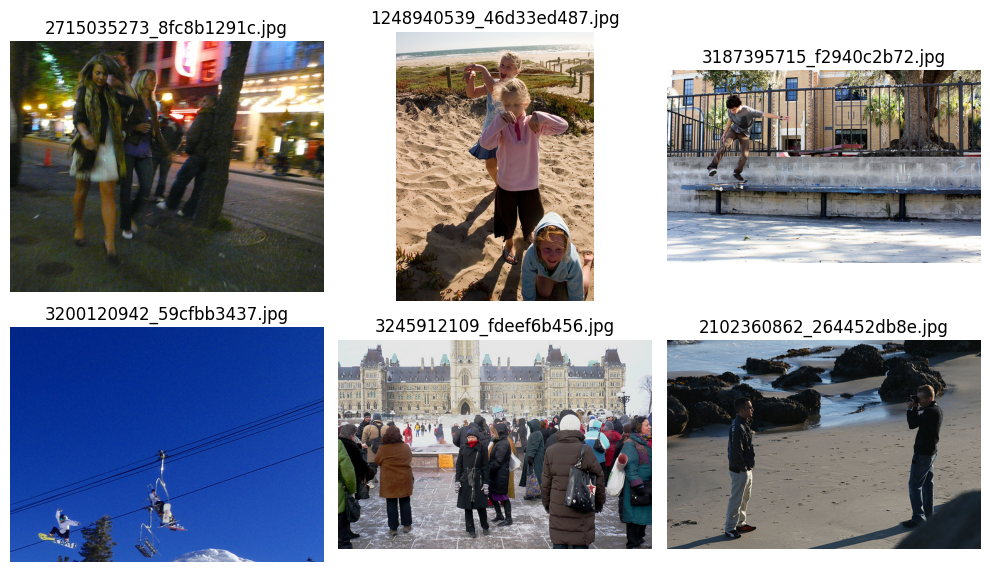

In [10]:
sample_paths = random.sample(image_paths, 6)

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for ax, img_path in zip(axes.flatten(), sample_paths):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(os.path.basename(img_path))
    ax.axis('off')

plt.tight_layout()
plt.show()

У нас много изображений с детьми (которые надо отфильтровать по условию задачи). Также есть изображения толпы, что может стать проблемой при детекции детей. Датасет содержит не только изображения людей

Получим пути к тестовым изображениям тоже

In [11]:
test_images_dir = os.path.join(data_dir, "to_upload", "test_images")

test_image_paths = [os.path.join(test_images_dir, f)
                    for f in os.listdir(test_images_dir)
                    if f.endswith((".jpg", ".png"))]

print(f"Всего тестовых изображений: {len(test_image_paths)}")

Всего тестовых изображений: 100


## Предобработка данных

In [12]:
crowd_df.head(3)

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3


Присвоим свой нейминг столбцам

In [13]:
crowd_df.columns = ["image",         # Имя файла изображения
                    "query_id",      # Идентификатор описания
                    "fraction_yes",  # Доля людей, подтвердивших, что описание соответствует
                    "count_yes",     # Количество человек, подтвердивших, что описание соответствует
                    "count_no"]       # Количество человек, подтвердивших, что описание не соответствует

print(crowd_df.head(3))

                       image                     query_id  fraction_yes  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2           0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2           0.0   

   count_yes  count_no  
0          3         0  
1          0         3  
2          0         3  


In [14]:
expert_df.head(3)

,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1.1,1.2
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2


In [15]:
expert_df.columns = ["image",         # Имя файла изображения
                     "query_id",      # Идентификатор описания
                     "expert_1",      # Оценка первого эксперта
                     "expert_2",      # Оценка второго эксперта
                     "expert_3"]       # Оценка третьего эксперта
print(expert_df.head(3))

                       image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   

   expert_3  
0         2  
1         2  
2         2  


In [16]:
train_df.tail(3)

,image,query_id,query_text
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .
5821,968081289_cdba83ce2e.jpg,2292406847_f366350600.jpg#2,A man rows his boat below .


In [17]:
train_df['image'].nunique()

1000

У нас всего 1000 картинок, а строчек много - потому что каждая картинка имеет несколько описаний

In [18]:
test_df.tail(3)

,Unnamed: 0,query_id,query_text,image
497,497,989851184_9ef368e520.jpg#2,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg
498,498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg
499,499,989851184_9ef368e520.jpg#4,The black dog has a toy in its mouth and a per...,989851184_9ef368e520.jpg


Сделаем лишний столбец в тесте индексом

In [19]:
test_df.set_index("Unnamed: 0", inplace=True)
test_df.index.name = None

In [20]:
test_df.tail(2)

,query_id,query_text,image
498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg
499,989851184_9ef368e520.jpg#4,The black dog has a toy in its mouth and a per...,989851184_9ef368e520.jpg


Смотрим колонки и пропуски

In [21]:
dfs = {"train": train_df, "crowd": crowd_df, "expert": expert_df, "test": test_df}

for name, df in dfs.items():
    print(f"=== {name} ===")
    print(df.info())
    print(f"количество дубликатов: {df.duplicated().sum()}")
    print("\n")

=== train ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None
количество дубликатов: 0


=== crowd ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   fraction_yes  47830 non-null  float64
 3   count_yes     47830 non-null  int64  
 4   count_no      47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None
количество дубликатов: 0


=== expert ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820


Пропусков нет, явных дубликатов нет ни в одном датасете. Проверим адекватность данных

In [22]:
expert_df.describe().T

,count,mean,std,min,25%,50%,75%,max
expert_1,5821.0,1.436695,0.787130,1.0,1.0,1.0,2.0,4.0
expert_2,5821.0,1.624463,0.856256,1.0,1.0,1.0,2.0,4.0
expert_3,5821.0,1.882151,0.904091,1.0,1.0,2.0,2.0,4.0


Данные выглядят адекватными. Эксперт 3 чуть более лоялен и чаще ставит оценку 2

In [23]:
crowd_df.describe().T

,count,mean,std,min,25%,50%,75%,max
fraction_yes,47830.0,0.068786,0.207532,0.0,0.0,0.0,0.0,1.0
count_yes,47830.0,0.208488,0.628898,0.0,0.0,0.0,0.0,5.0
count_no,47830.0,2.820155,0.656676,0.0,3.0,3.0,3.0,6.0


Данные тоже выглядят адекватно. Люди чаще отмечают, что описание не соответствует картинке


### Агрегация оценок, для получения итогового таргета

Т.к.наша задача в таргете получить вероятность совпадения, то на мой вгзляд более справедливым будет взять среднюю оценку экспертов( исключая те случаи, где все эксперты поставили разную оценку), а не определять мажоритарным голосованием (за какую оценку больше проголосовало - ту и ставим). Затем нормализовать эту оценку и добавить крауд в соотношении  0.6 эксперт + 0.4 крауд, для того,чтобы сгладить спорные моменты.

In [24]:
def mean_vote(row):
    """
    Возвращает среднюю оценку по трём экспертам.
    Если все три оценки разные — возвращает None.
    """
    votes = [row["expert_1"], row["expert_2"], row["expert_3"]]
    # если множество из голосов равно 3 - все оценки разные
    if len(set(votes)) == 3:
        return None
    return sum(votes) / len(votes)

Применим к экспертным данным и дропнем в новый датасет (после фильтрации) где нет единой оценки

In [25]:
expert_df["mean_vote"] = expert_df.apply(mean_vote, axis=1)
expert_mean_df = expert_df.dropna(subset=["mean_vote"])

In [26]:
expert_mean_df = expert_mean_df.drop(columns=['expert_1','expert_2','expert_3'])

 Посмотрим сколько % инфы потеряли, когда отбросили строки без единой оценки

In [27]:
round((1 - expert_mean_df.shape[0]/expert_df.shape[0])*100,2)

2.16

Потеряли приемлемо. Получили df со средней экспертной оценкой, нормализуем ее

In [28]:
scaler = MinMaxScaler()
expert_mean_df["expert_norm"] = scaler.fit_transform(expert_mean_df[["mean_vote"]])

In [29]:
expert_mean_df.head(3)

,image,query_id,mean_vote,expert_norm
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1.333333,0.111111
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1.333333,0.111111
2,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1.666667,0.222222


добавим крауд чтобы сгладить спорные пары. Нас интересует колонка fraction_yes - доля людей сказавших,что изображение соответствует описанию


In [30]:
crowd_df.head(3)

,image,query_id,fraction_yes,count_yes,count_no
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3


Объединим датасеты crowd_df и expert_mean_df по двум ключам: image и query_id. Соединять будем через left, потому что экспертные оценки важны (при inner мы можем потерять строки где нет оценки крауда, а так мы можем просто оставить в них нгормализованную экспертную оценку и это тоже будет ок)

In [31]:
merged_df = expert_mean_df.merge(
    crowd_df[["image", "query_id", "fraction_yes"]], on=["image", "query_id"], how="left")

Собираем финальный таргет: 60% эксперт + 40% крауд

In [32]:
merged_df["target"] = 0.6 * merged_df["expert_norm"] + 0.4 * merged_df["fraction_yes"] # если fraction_yes Nan то в сумме Nan

# Если fraction_yes отсутствует (NaN) — заполняем нормализованной экспертной
merged_df["target"] = merged_df["target"].fillna(merged_df["expert_norm"])

In [33]:
merged_df.tail(3)

,image,query_id,mean_vote,expert_norm,fraction_yes,target
5692,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1.333333,0.111111,0.000000,0.066667
5693,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1.000000,0.000000,NaN,0.000000
5694,997722733_0cb5439472.jpg,486917990_72bd4069af.jpg#2,3.000000,0.666667,0.333333,0.533333


Кажется, что оценки слишком низкие. Посмотрим не и прортил ли нам крауд оценки, есть ли вообще высокая вероятность?

In [34]:
merged_df.query('target == target.max()')

,image,query_id,mean_vote,expert_norm,fraction_yes,target
49,1131932671_c8d17751b3.jpg,1131932671_c8d17751b3.jpg#2,4.0,1.0,1.0,1.0
76,1174629344_a2e1a2bdbf.jpg,1174629344_a2e1a2bdbf.jpg#2,4.0,1.0,1.0,1.0
182,1322323208_c7ecb742c6.jpg,1322323208_c7ecb742c6.jpg#2,4.0,1.0,1.0,1.0
300,1402640441_81978e32a9.jpg,2844641033_dab3715a99.jpg#2,4.0,1.0,1.0,1.0
329,1425069308_488e5fcf9d.jpg,1425069308_488e5fcf9d.jpg#2,4.0,1.0,1.0,1.0
...,...,...,...,...,...,...
5441,541063517_35044c554a.jpg,2759860913_f75b39d783.jpg#2,4.0,1.0,1.0,1.0
5506,583174725_6b522b621f.jpg,583174725_6b522b621f.jpg#2,4.0,1.0,1.0,1.0
5519,670609997_5c7fdb3f0b.jpg,670609997_5c7fdb3f0b.jpg#2,4.0,1.0,1.0,1.0
5583,758921886_55a351dd67.jpg,758921886_55a351dd67.jpg#2,4.0,1.0,1.0,1.0


Ура, у нас есть нормальный таргет. Теперь добавим его в train по ключу. В train и merged_df у нас есть image и query_id. Будем мерджить по двум ключам, чтобы получить точное совпадение

In [35]:
train_df.head(3)

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [36]:
main_df = train_df.merge(merged_df[["image", "query_id", "target"]],
    on=["image", "query_id"], how="inner")

In [37]:
print(train_df.shape)
print(merged_df.shape)
print(main_df.shape)

(5822, 3)
(5695, 6)
(5695, 4)


итого, наш обучающий датасет main_df:

In [38]:
main_df.head(3)

,image,query_id,query_text,target
0,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
1,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.133333
2,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000


In [39]:
main_df.isna().sum()

,0
image,0
query_id,0
query_text,0
target,0


## Фильтрация запрещенных изображений

Если мы будем полагаться только на текст или только на картинки, то получим либо «слишком много ложных срабатываний» (как например если в описании будет указано baby kitty, а мы отфильтруем из-за слова baby), если мы будем полагаться только на сеть, фильрующую по возрасту, она будет плохо работать с подростками (14 - 20 лет могут выглядеть одинаково). Самое адекватное решение — комбинировать два сигнала.

Возьмем стоп-слова,которые воспринимаются однозначно:

schoolboy, schoolgirl, toddler, preschooler, infant, kindergartener, pupil, baby carriage, playground child и отфильтруем строки с запрещенными словами.
Сомнительные слова (newborn, baby, child, kid, teen, girl, boy и т.п.)
нельзя фильтровать без картинки. junior тоже сомнительное слово, т.к может испрользоваться в сочетании «junior developer», «junior engineer»

В train бан-изображения мы удалим, чтобы модель не училась на запрещённом.


В тесте такие строки оставим, но не будем обрабатывать их через ResNet (не векторизуем картинки), а сразу запишем дисклеймер: 'This image is unavailable in your country in compliance with local laws'

### Текстовая фильтрация

Свяжем строки train_filtered с их файлами на диске.

In [40]:
main_df["image_path"] = main_df["image"].apply(lambda x: os.path.join(train_images_dir, x))
test_df["image_path"] = test_df["image"].apply(lambda x: os.path.join(test_images_dir, x))

In [41]:
# слова, которые однозначно указывают на детей
hard_ban=['schoolboy', 'schoolgirl', 'toddler', 'preschooler',
          'kindergartener', 'pupil', 'baby carriage', 'playground child',
          'school teen', 'baby girl', 'baby boy', 'children',
          'young girl', 'young boy']

# слова, которые могут быть двусмысленными (пока только помечаем)
soft_ban = ['newborn', 'baby', 'child', 'kid', 'kids', 'infant', 'boy', 'young',
            'girl', 'teen', 'teenager', 'youth', 'adolescent', 'youngster', 'high school student', 'junior']


In [42]:
def filter_by_stopwords(df, text_column="query_text"):
    """
    Фильтруем текст по стоп-словам
    """
    df = df.copy()
    text_lower = df[text_column].str.lower()

    # Жёсткий бан → сразу запрещаем
    df["is_banned"] = text_lower.str.contains("|".join(hard_ban), na=False)

    # Сомнительные слова → пока только помечаем для следующего этапа
    df["has_soft_flag"] = text_lower.str.contains("|".join(soft_ban), na=False)

    return df

In [43]:
# Сначала помечаем строки по стоп-словам
train_marked = filter_by_stopwords(main_df)

# Определяем все изображения, которые встречаются хотя бы в одном забаненном описании
banned_images = train_marked.loc[train_marked["is_banned"], "image"].unique()

# Убираем все строки с этими изображениями
train_filtered = train_marked.loc[~train_marked["image"].isin(banned_images)].copy()

print("До фильтрации train:", main_df.shape)
print("После фильтрации train:", train_filtered.shape)

До фильтрации train: (5695, 5)
После фильтрации train: (3801, 7)


In [44]:
train_filtered['image'].nunique()

695

Из тысячи изображений в трейне отфильровали примерно треть. Аналогично поступим с тестом.

In [45]:
# Test: оставляем все строки, но помечаем
test_marked = filter_by_stopwords(test_df)
test_marked[["query_text", "is_banned", "has_soft_flag"]].tail(5)

,query_text,is_banned,has_soft_flag
495,A black dog has a dumbbell in his mouth .,False,False
496,A black dog has a dumbbell in his mouth lookin...,False,False
497,A black dog holding a weight in its mouth stan...,False,False
498,A black dog holds a small white dumbbell in it...,False,False
499,The black dog has a toy in its mouth and a per...,False,False


Осталось дофильтровать сомнительные случаи (возьмем только те, у кого есть флаг у мягкого фильтра)

Функция оценки возраста

In [46]:
# def predict_min_age(image_path):
#     """
#     Возвращает минимальный возраст на изображении или None, если лиц нет.
#     """
#     try:
#         analysis = DeepFace.analyze(img_path=image_path, actions=["age"], enforce_detection=False)
#         if isinstance(analysis, list):
#             ages = [a["age"] for a in analysis]
#         else:
#             ages = [analysis["age"]]
#         return min(ages)
#     except Exception as e:
#         print(f"Ошибка при обработке {image_path}: {e}")
#         return None

Кеширование результатов

In [47]:
# def build_age_cache(df, cache_file="predicted_ages.csv"):
#     """
#     Прогоняем уникальные изображения через модель возраста и сохраняем в CSV.
#     """
#     results = []

#     for _, row in tqdm(df.iterrows(), total=len(df)):
#         img_path = row["image_path"]
#         min_age = predict_min_age(img_path)
#         results.append({"image_path": img_path, "min_age": min_age})

#     # Сохраняем результат в CSV
#     pd.DataFrame(results).to_csv(cache_file, index=False)
#     print(f"Результаты сохранены в {cache_file}")

#     return pd.DataFrame(results)

Фильтрация с учетом кеша

In [48]:
# def filter_with_age_cache(df, age_cache, age_threshold=16):
#     """
#     Фильтруем строки по soft-flag и предсказанному возрасту из кеша.
#     """
#     df = df.merge(age_cache, on="image_path", how="left")
#     keep_mask = (
#         (~df["has_soft_flag"]) |      # нет soft-флага → оставляем
#         (df["min_age"].isna()) |      # лицо не найдено → оставляем
#         (df["min_age"] >= age_threshold)  # возраст >= threshold → оставляем
#     )
#     return df[keep_mask].reset_index(drop=True)

Фильтруем изображения только у мягкого фильтра (берём только строки с has_soft_flag=True)

In [49]:
# soft_images_train = train_filtered[train_filtered["has_soft_flag"]].copy()
# soft_images_test = test_marked[test_marked["has_soft_flag"]].copy()

In [50]:
# soft_images_train['image'].nunique()

Оставим только уникальные катринки (без дополнительных строк с описанием)

In [51]:
# soft_images_train = soft_images_train.drop_duplicates(subset="image").copy()
# soft_images_test = soft_images_test.drop_duplicates(subset="image").copy()

Для трейна это 434 изображения.

In [52]:
# cache_file = os.path.join(data_dir, "predicted_ages.csv")
# age_cache = build_age_cache(soft_images_train, cache_file=cache_file)

In [53]:
# files.download("data/predicted_ages.csv")

In [54]:
# age_cache = pd.read_csv("data/predicted_ages.csv")
# age_cache

Мы все это посчитали и теперь, чтобы не тратить время на пересчет можно подцепить посчитанный файл с гит (оставлю на всякий *ссылку*).

In [55]:
# url_git = "https://raw.githubusercontent.com/Shostaklisa/image-text-matching/main/data_git/predicted_ages.csv"

# # Загружаем CSV напрямую в DataFrame
# age_cache = pd.read_csv(url_git)

# age_cache.head(3)

In [56]:
# age_cache.min_age.unique()

Хм. нейросеть посчитала нам что все взрослые. но так ли это? выведем на экран картинки с софт флагом

In [57]:
# # @title
# sample_paths = random.sample(list(soft_images_train["image_path"]), 6)

# fig, axes = plt.subplots(2, 3, figsize=(8, 5))
# for ax, img_path in zip(axes.flatten(), sample_paths):
#     img = Image.open(img_path)
#     ax.imshow(img)
#     ax.set_title(img_path.split("/")[-1])
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

Чтож. Идея была хорошая, но нейросеть врет. Тогда пройдемся еще раз стоп словами.

In [58]:
# дополнительный бан
add_ban = ['newborn', 'baby', 'child', 'kid', 'kids', 'infant', 'boy', 'girl']
hard_ban_extended = hard_ban + add_ban

Сначала казалось логичным удалять изображения, а не строки с стоп словами. Но так удаляется очень много лишнего. Если же удалять строки с стоп-словами, то в любом случае изобраение, где главное действующее лицо - ребенок будет удалено. Однако эта фильтрация сработает только в том случае,где изображение соответствует описанию хоть немного (если картинка вообще не соотносится с описанием фильтровать по словам бессмысленно)

In [59]:
# Создаём булеву маску: True, если строка должна быть удалена
text_lower = main_df["query_text"].str.lower()
delete_condition = text_lower.str.contains("|".join(hard_ban_extended), na=False) & (main_df["target"] > 0.15)
# Находим уникальные изображения, которые попадут под фильтр
banned_images = main_df.loc[delete_condition, "image"].unique()
# Убираем строки с этими изображениями
filtered_train = main_df.loc[~main_df["image"].isin(banned_images)].copy()

print("Строк после фильтрации трейн:", filtered_train.shape)

Строк после фильтрации трейн: (3841, 5)


Берём случайные 6 изображений из оставшихся

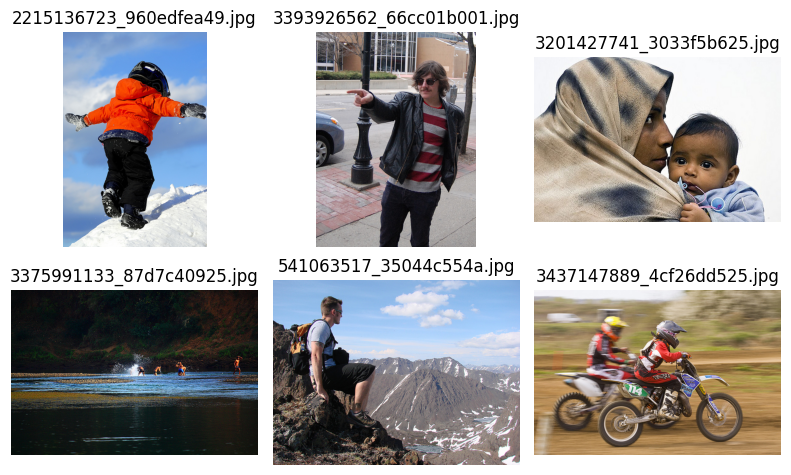

In [60]:
sample_paths = random.sample(
    list(filtered_train["image_path"].unique()),
    min(6, filtered_train["image_path"].nunique())
)

fig, axes = plt.subplots(2, 3, figsize=(8, 5))
for ax, img_path in zip(axes.flatten(), sample_paths):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(os.path.basename(img_path))
    ax.axis('off')

plt.tight_layout()
plt.show()

Аналогично поступаем с тестом (но не используем условие минимальной достоверности описания изображения, потому что не можем)

In [61]:
text_lower_test = test_df["query_text"].str.lower()
banned_images_test = test_df.loc[text_lower_test.str.contains("|".join(hard_ban_extended), na=False), "image"].unique()
test_marked = test_df.copy()
test_marked["is_banned"] = test_marked["image"].isin(banned_images_test)
print(test_marked[["query_id", "image", "is_banned"]].head(5))

                      query_id                      image  is_banned
0  1177994172_10d143cb8d.jpg#0  1177994172_10d143cb8d.jpg       True
1  1177994172_10d143cb8d.jpg#1  1177994172_10d143cb8d.jpg       True
2  1177994172_10d143cb8d.jpg#2  1177994172_10d143cb8d.jpg       True
3  1177994172_10d143cb8d.jpg#3  1177994172_10d143cb8d.jpg       True
4  1177994172_10d143cb8d.jpg#4  1177994172_10d143cb8d.jpg       True


In [62]:
test_marked[test_marked["is_banned"]==True].sum()

,0
query_id,1177994172_10d143cb8d.jpg#01177994172_10d143cb...
query_text,"Two blonde boys , one in a camouflage shirt an..."
image,1177994172_10d143cb8d.jpg1177994172_10d143cb8d...
image_path,data/to_upload/test_images/1177994172_10d143cb...
is_banned,215


In [63]:
filtered_test = test_marked[test_marked["is_banned"]==False] # данные с которыми будем работать
ban_test =  test_marked[test_marked["is_banned"]==True] #запрещенные изображения, которые сразу выдают дисклеймер

In [64]:
filtered_test.shape

(285, 5)

В тесте отфильтровывается почти 45% изображений. Так себе фильтр, но какой есть.может доработаем

В итоге наши отфильтрованные рабочие датасеты называются **filtered_train** и **test_marked**

## Извлечение текстовых эмбеддингов (BERT)

In [65]:
MODEL_NAME = "bert-base-uncased"

In [66]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()  # выключаем dropout

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [67]:
texts = filtered_train["query_text"].astype(str).tolist()

получаем эмбеддинги

In [68]:
text_embeddings = []

In [69]:
with torch.no_grad():
    for text in tqdm(texts):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
        outputs = model(**inputs)
        # берём [CLS] токен (первый в последовательности)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        text_embeddings.append(cls_embedding)

text_embeddings = np.array(text_embeddings)
print("Shape of text_embeddings:", text_embeddings.shape)

100%|██████████| 3841/3841 [18:22<00:00,  3.48it/s]

Shape of text_embeddings: (3841, 768)


In [70]:
np.save("text_embeddings.npy", text_embeddings)

и для теста


In [71]:
# Список текстов из теста
texts_test = filtered_test["query_text"].astype(str).tolist()

text_embeddings_test = []
with torch.no_grad():
    for text in tqdm(texts_test):
        inputs = tokenizer(text, return_tensors="pt", truncation=True,
            padding="max_length", max_length=64)
        outputs = model(**inputs)
        # Берём CLS-токен (первый в последовательности) как эмбеддинг текста
        cls_embedding_test = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        text_embeddings_test.append(cls_embedding_test)

# Превращаем список в массив NumPy
text_embeddings_test = np.array(text_embeddings_test)
print("Shape of test text embeddings:", text_embeddings_test.shape)

100%|██████████| 285/285 [01:17<00:00,  3.69it/s]

Shape of test text embeddings: (285, 768)


## Векторизация изображений

In [72]:
image_paths = filtered_train['image_path'].tolist()

Загружаем модель, предварительно обученную на датасете ImageNet. Берем все слои кроме последнего

In [73]:
resnet18 = models.resnet18(pretrained=True)
resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-1])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 78.0MB/s]


Отключаем обучение, модель работает в режиме инференса (используем как фиче-экстрактор для эмбеддингов)

In [74]:
resnet18.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Преобразования для изображений (нормализация по ImageNet)

In [75]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Получаем эмбеддинги **для трейна**

In [76]:
image_embeddings = []
for img_path in tqdm(image_paths):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        emb = resnet18(img_tensor).squeeze().numpy()
    image_embeddings.append(emb)

image_embeddings = np.array(image_embeddings)
print("Shape of image embeddings:", image_embeddings.shape)
np.save("image_embeddings_resnet18.npy", image_embeddings)

100%|██████████| 3841/3841 [06:27<00:00,  9.92it/s]


Shape of image embeddings: (3841, 512)


размерность правильная (3841 картинок, У ResNet-18 последний сверточный блок содержит 512 каналов. После avgpool каждый канал усредняется - получается вектор из 512 значений).

Наша задача — построить модель, которая по текстовому описанию и картинке предсказывает насколько они соответствуют друг другу (вероятность от 0 до 1).

у нас есть:

**text_embeddings** (размерность (n, 768))

**image_embeddings** (размерность (n, 512) из ResNet-18)

**target** (комбинированная оценка соответствия от экспертов/крауда)

Теперь нам **нужно их объединить в итоговый вектор** признаков и подготовить данные для модели.

Проверяем, что количество текстов и изображений совпадает

In [77]:
assert text_embeddings.shape[0] == image_embeddings.shape[0]

Также получаем **эмбеддинги для тестовых изображений**

In [78]:
image_paths_test = filtered_test['image_path'].tolist()
image_embeddings_test = []

for img_path in tqdm(image_paths_test):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        emb = resnet18(img_tensor).squeeze().numpy()
    image_embeddings_test.append(emb)

image_embeddings_test = np.array(image_embeddings_test)

100%|██████████| 285/285 [00:28<00:00,  9.95it/s]


## Конкатенируем по оси признаков

 Мы берём каждую строку текста и добавляем к ней соответствующую строку картинки, формируя один длинный вектор (размерность признаков меняется: 768 + 512 = 1280). Смысл объединения эмбеддингов в том, чтобы модель одновременно “видела” текст и картинку и могла учиться находить соответствие между ними.

Когда мы склеиваем [текстовые признаки + признаки картинки] в один длинный вектор (1280 чисел), мы получаем обе модальности в одной строке данных. Модель получает возможность учиться на совместных закономерностях: например, что текст «красная машина» хорошо совпадает с картинкой, где есть красный объект на четырёх колёсах.

In [79]:
features = np.concatenate([text_embeddings, image_embeddings], axis=1)
print("Combined feature matrix shape:", features.shape)

Combined feature matrix shape: (3841, 1280)


In [80]:
features

array([[-0.047877  ,  0.05141543, -0.272813  , ...,  3.4558144 ,
         3.262314  ,  1.381283  ],
       [-0.047877  ,  0.05141543, -0.272813  , ...,  1.3517823 ,
         1.7419662 ,  0.82469296],
       [-0.047877  ,  0.05141543, -0.272813  , ...,  0.29131505,
         1.7827852 ,  0.3951454 ],
       ...,
       [ 0.449086  ,  0.662357  , -0.14189048, ...,  0.16220093,
         3.9092617 ,  0.632548  ],
       [-0.0815836 ,  0.05398389, -0.82227427, ...,  0.63114923,
         1.1907165 ,  0.53927493],
       [-0.52356017, -0.2747075 , -0.8157735 , ...,  1.3090591 ,
         0.6644823 ,  0.15310195]], dtype=float32)

In [81]:
targets = filtered_train["target"].values

In [82]:
targets

array([0.        , 0.        , 0.        , ..., 0.        , 0.33333333,
       0.33333333])

In [83]:
df_train = pd.DataFrame({
    "query_id": filtered_train["query_id"].values,
    "image_path": filtered_train["image_path"].values,
    "target": targets,
    "features": list(features)  # каждый вектор как объект
})

In [84]:
df_train.head()

,query_id,image_path,target,features
0,2549968784_39bfbe44f9.jpg#2,data/to_upload/train_images/3155451946_c0862c7...,0.000000,"[-0.047876995, 0.05141543, -0.272813, -0.07229..."
1,2549968784_39bfbe44f9.jpg#2,data/to_upload/train_images/3222041930_f642f49...,0.000000,"[-0.047876995, 0.05141543, -0.272813, -0.07229..."
2,2549968784_39bfbe44f9.jpg#2,data/to_upload/train_images/486712504_36be4490...,0.000000,"[-0.047876995, 0.05141543, -0.272813, -0.07229..."
3,2718495608_d8533e3ac5.jpg#2,data/to_upload/train_images/1056338697_4f7d7ce...,0.066667,"[0.30646086, 0.18739651, -0.31747913, -0.14775..."
4,2718495608_d8533e3ac5.jpg#2,data/to_upload/train_images/2616643090_4f2d2d1...,0.000000,"[0.30646086, 0.18739651, -0.31747913, -0.14775..."


Выделим валидационный сет (в этом проекте не будем использовать кросс-валидацию, потому что это демонстрационный проект. Нам лучше посчитать быстрее,небольшая потеря точности не так критична, надо просто показать что идея работает)

Преобразуем данные в тензоры

In [85]:
X = np.array(df_train['features'].tolist())
y = df_train['target'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

С **тестовыми эмбеддингами** поступаем также

In [86]:
features_test = np.concatenate([text_embeddings_test, image_embeddings_test], axis=1)
print("Combined feature_test matrix shape:", features_test.shape)

Combined feature_test matrix shape: (285, 1280)


## MLP модель

Преобразуем данные тренировочной и валидационной выборки в тензоры

In [87]:
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32)).unsqueeze(1)
X_val_t = torch.from_numpy(X_val.astype(np.float32))
y_val_t = torch.from_numpy(y_val.astype(np.float32)).unsqueeze(1)

Конвертируем features_test в torch tensor

In [88]:
features_test_t = torch.from_numpy(features_test.astype(np.float32))

In [89]:
class MLP(nn.Module):
    def __init__(self, input_dim=1280):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=X_train.shape[1])

In [90]:
epochs = 50
batch_size = 64
lr = 1e-3

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()  # для регрессии

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_t.size(0))
    for i in range(0, X_train_t.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train_t[indices], y_train_t[indices]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_t)
        val_loss = criterion(val_pred, y_val_t)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Val MSE: {val_loss.item():.4f}")

Epoch 10, Val MSE: 0.0522
Epoch 20, Val MSE: 0.0485
Epoch 30, Val MSE: 0.0490
Epoch 40, Val MSE: 0.0453
Epoch 50, Val MSE: 0.0492


In [91]:
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_t).squeeze().numpy()

mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred)

print(f"MLP -> MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

MLP -> MAE: 0.1409, MSE: 0.0492, RMSE: 0.2218, R²: 0.2620


In [92]:
model.eval()
with torch.no_grad():
    y_pred_allowed = model(features_test_t).squeeze().numpy()

## Собираем финальный submission

In [93]:
submission = []

# Разрешённые изображения
for idx, row in filtered_test.iterrows():
    submission.append({
        'query_id': row['query_id'],
        'image_path': row['image_path'],
        'predicted_target': float(y_pred_allowed[filtered_test.index.get_loc(idx)])
    })

# Запрещённые изображения
for idx, row in ban_test.iterrows():
    submission.append({
        'query_id': row['query_id'],
        'image_path': row['image_path'],
        'predicted_target': "This image is unavailable in your country in compliance with local laws"
    })

# Собираем в DataFrame и сохраняем
submission_df = pd.DataFrame(submission)
submission_df.to_csv("submission.csv", index=False)

In [107]:
submission_df.tail(3)

,query_id,image_path,predicted_target
497,989754491_7e53fb4586.jpg#2,data/to_upload/test_images/989754491_7e53fb458...,This image is unavailable in your country in c...
498,989754491_7e53fb4586.jpg#3,data/to_upload/test_images/989754491_7e53fb458...,This image is unavailable in your country in c...
499,989754491_7e53fb4586.jpg#4,data/to_upload/test_images/989754491_7e53fb458...,This image is unavailable in your country in c...


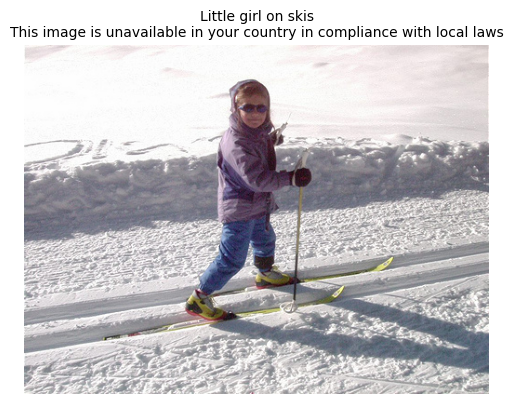

In [114]:

# Берём случайную строку
row = submission_df.sample(1, random_state=random.randint(0, 10000)).iloc[0]

# Открываем картинку
img = Image.open(row['image_path']).convert("RGB")

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")

# Находим текст запроса (из test_marked по query_id)
query_text = test_marked.loc[test_marked['query_id'] == row['query_id'], 'query_text'].values[0]

# Предсказание или дисклеймер
pred = row['predicted_target']
if isinstance(pred, float) or isinstance(pred, int):
    title = f"{query_text}\nPrediction: {pred:.2f}"
else:
    title = f"{query_text}\n{pred}"

plt.title(title, fontsize=10)
plt.show()

## Вывод

демонстрационная система «текст ↔ изображение» (корреляция / вероятность)

 **Цель проекта** - сделать демонстрационную систему «текст ↔ изображение» (корреляция / вероятность). Необходимо построить модель, которая по паре (текст описания, изображение) выдаёт число вероятность/оценку того, насколько изображение соответствует описанию. В качестве таргета использовались комбинированные оценки экспертов/крауда. Также в проекте реализована юридическая фильтрация - для изображений детей до 16 лет на выходе возвращается дисклеймер.

**Что было реализовано**

- Предобработка и фильтрация

- Убраны запрещённые изображения из train (фильтрация по ключевым словам/правилам).

- Для теста сделали маркировку (test_marked) с булевым флагом is_banned.

-  Для получения текстовых эмбеддингов Использовали BERT (bert-base-uncased) для англ языка.
- далее проведена векторизация изображений. В качестве фиче-экстрактора использовали ResNet-18.
- Собрали признаки. Сделали конкатенацию по текстовым эмбеддингам и изображений
- Собрали df_train / df_test с колонками query_id, image_path, target, features (features — список векторов).
- реализовали MLP с архитектурой :Linear(1280,1024) - BatchNorm1d - LeakyReLU/ ReLU - Dropout(0.3) - Linear(1024,512) - BatchNorm? - ReLU - Dropout(0.2) - Linear(512,256) - ReLU - Linear(256,1)
epochs=50, batch_size=64, optimizer=Adam (lr=1e-3), criterion=MSELoss.

Результаты: лучший вариант показал MAE = 0.1305, MSE = 0.0464, RMSE ≈ 0.2154, R² = 0.3042.

Аналогично обработали тестовый датасет:
Для filtered_test посчитаны text + image эмбеддинги → features_test .

- сформировали submission:

Для разрешённых: predicted_target =  предсказание вероятности.

Для запрещённых: predicted_target = "This image is unavailable in your country in compliance with local laws".

